<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/9_Feature_engineer_select/9_6_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 9: Principles of Feature Engineering and Selection

This notebook contains interactive content from an early draft of the university textbook <a href="https://github.com/neonwatty/machine-learning-refined/tree/main">
Machine Learning Refined (2nd edition) </a>.

The final draft significantly expands on this content and is available for <a href="https://github.com/neonwatty/machine-learning-refined/tree/main/chapter_pdfs"> download as a PDF here</a>.

# 9.6 Feature Selection via Boosting

In this Section we discuss on popular way of performing feature selection, called *boosting* or *forward stagewise selection*. Boosting is a 'bottom-up' approach to feature selection wherein we gradually build up our model *one feature at a time* by training a *supervised learner*, *sequentially* one weight at-a-time.  Doing this gives human interpreters an easier way to gauge the importance of individual features, and likewise lets them more easily derive insight about a particular phenomenon.

In [5]:
# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path 

# clone datasets
if not Path('chapter_9_datasets').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/9_Feature_engineer_select/chapter_9_datasets
else:
    print('chapter_9_datasets already cloned!')

# clone library subdirectory
if not Path('chapter_9_library').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/9_Feature_engineer_select/chapter_9_library
else:
    print('chapter_9_library already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_9_library') 

# import section helper
import section_9_6_helpers

# dataset paths 
data_path_1 = 'chapter_9_datasets/boston_housing.csv'
data_path_2 = 'chapter_9_datasets/credit_dataset.csv'

# standard imports
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

import IPython, copy
from IPython.display import Image, HTML

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
chapter_9_datasets already cloned!
chapter_9_library already cloned!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Boosting based feature selection

In tuning a model's weights one-at-a-time we of course do *not* want to tune them *in any order*, e.g., we do not want to just tune them at random, as this will not aid human interpretation.   Instead we want to tune them *starting with the most important feature-touching weight* (that is $w_1,\,...,w_N$), then tune the *second most important feature-touching weight*, then the third, and so forth.  Here by 'importance' we mean how each *input feature* contributes to the final supervised learning model as determined by its associated weight, or in other words how each contributes to minimizing the corresponding cost as much as possible. 

Now at the start of the weight learning process *we begin with just the bias*.  That is we begin with a  model - which we will denote as $\text{model}_0$ - that consists of the bias $w_0$ alone

\begin{equation}
\text{model}_0\left(\mathbf{x},\mathbf{w}\right) = w_0.
\end{equation}

To begin we first tune the *bias* parameter $w_0$ by minimizing an appropriate cost (depending on whether we are solving a regression or classification problem) over *this variable alone*.  For example, if we are performing regression employing the Least Squares cost and we minimize  

\begin{equation}
\frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_0^{\,}\left(\mathbf{x},\mathbf{w}\right)  - \overset{\,}{y}_{p}^{\,}\right)^{2} =  \frac{1}{P}\sum_{p=1}^{P}\left(w_0^{\,}   - \overset{\,}{y}_{p}^{\,}\right)^{2}
\end{equation}

which gives the optimal value for our bias $w_0^{\,} \longleftarrow w_0^{\star}$.  Thus our starting model is now

\begin{equation}
\text{model}_0^{\,}\left(\mathbf{x},\mathbf{w}\right) = w_0^{\star}.
\end{equation}

Next, at the first round of boosting, in order to determine the most important feature-touching weight $w_1,\,w_2,\,...,w_N$ we *try out each one* by minimizing a cost over each one individually having already set the bias optimally.  That is we minimize $N$ cost functions over a single feature-touching weight alone, so e.g., in the case of Least Squares regression the $n^{th}$ of these subproblems takes the form

\begin{equation}
 \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_0^{\,}\left(\mathbf{x}_p,\mathbf{w}\right) + w_n^{\,}x_{n,p}   - \overset{\,}{y}_{p}^{\,}\right)^{2} =  \frac{1}{P}\sum_{p=1}^{P}\left(w_0^{\star} + x_{n,p}w_n^{\,}   - \overset{\,}{y}_{p}^{\,}\right)^{2}.
\end{equation}

Again, the bias weight has already been set optimally and is *not* tuned in each subproblem above - we only tune the weight $w_n$.  

The feature-touching weight that produces the *smallest* value from these $N$ subproblems corresponds to the individual feature that helps best explain the relationship between the input and output of our dataset, and it is therefore most important feature-touching weight we learn.  Denoting this weight as $w_{s_1}$, we then *fix* it at its optimally determined value $w_{s_1}^{\,} \longleftarrow w_{s_1}^{\star}$ (discarding all other weights tuned in each of these subproblems) and update our `model` accordingly.  We call our updated `model` $\text{model}_1$ which is a sum of our optimal bias and this newly determined optimal feature-touching weight

\begin{equation}
\text{model}_1^{\,}\left(\mathbf{x},\mathbf{w}\right) = \text{model}_0^{\,}\left(\mathbf{x},\mathbf{w}\right) + x_{s_1}^{\,}w_{s_1}^{\star}= w_0^{\star} + x_{s_1}^{\,}w_{s_1}^{\star}.
\end{equation}

Next, at the second round of boosting, we determine the *second* most important feature-touching weight we then sweep through the remaining $N-1$ weights (i.e., excluding $w_0$ and $w_{s_1}$ which we have already tuned) and try out each one individually by minimizing a cost over each weight independently.  e.g., in the case of Least Squares regression $n^{th}$ such cost looks like

\begin{equation}
 \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_1^{\,}\left(\mathbf{x}_p,\mathbf{w}\right) + w_n^{\,}x_{n,p}   - \overset{\,}{y}_{p}^{\,}\right)^{2} =  \frac{1}{P}\sum_{p=1}^{P}\left(w_0^{\star} + x_{s_1}^{\,}w_{s_1}^{\star} + x_{n,p}w_n^{\,}   - \overset{\,}{y}_{p}^{\,}\right)^{2}.
\end{equation}

Again with each of these subproblems $w_0^{\star}$ and $w_{s_1}^{\star}$ have already been set optimally, we only tune the weight $w_n$ in each instance.

The feature-touching weight that produces the *smallest* value from these $\left(N-1\right)$ subproblems corresponds to the second most important feature that helps explain the relationship between the input and output of our dataset.  Denoting the cost minimizing weight $w_{s_2}$, we then *fix* the value of this weight at its optimally determined value $w_{s_2}^{\,} \longleftarrow w_{s_2}^{\star}$ (and none of the other weights tuned in each of these subproblems) and update our model accordingly.  We call our updated model $\text{model}_2$ which is a sum of our first three optimally tuned weights

\begin{equation}
\text{model}_2^{\,}\left(\mathbf{x},\mathbf{w}\right) = \text{model}_1^{\,}\left(\mathbf{x},\mathbf{w}\right) + x_{s_2}^{\,}w_{s_2}^{\star}= w_0^{\star} + x_{s_1}^{\,}w_{s_1}^{\star} + x_{s_2}^{\,}w_{s_2}^{\star}.
\end{equation}

In general, at the $M^{th}$ round of boosting, to determine the $M^{th}$ most important feature-touching weight (where $M\geq 2$) we follow the same pattern.  When we do this we have already determined the optimal setting of our bias and the top $M-1$ most important feature-touching weights, our model taking the form

\begin{equation}
\text{model}_{M-1}^{\,}\left(\mathbf{x},\mathbf{w}\right) = \text{model}_{M-2}^{\,}\left(\mathbf{x},\mathbf{w}\right) + x_{s_{m-1}}^{\,}w_{s_{M-1}}^{\star}= w_0^{\star} + x_{s_1}^{\,}w_{s_1}^{\star} + \cdots + x_{s_{M-1}}^{\,}w_{s_{M-1}}^{\star}.
\end{equation}

where here $w_{M-1}^{\star}$ denotes our optimally tuned $\left(M-1\right)^{th}$ most important feature-touching weight.


We then must setup and solve $\left(N-M + 1\right)$ subproblems, one for each feature-touching weight we have not yet resolved.  For example, in the case of Least Squares regression the $n^{th}$ of these  takes the form

\begin{equation}
 \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_{M-1}^{\,}\left(\mathbf{x}_p,\mathbf{w}\right) + w_n^{\,}x_{n,p}   - \overset{\,}{y}_{p}^{\,}\right)^{2}
\end{equation}

where again in each case we only tune the individual weight $w_n$.  Denoting this weight $w_{s_M}$ we then fix its optimal value $w_{s_M}^{\,} \longleftarrow w_{s_M}^{\star}$ and add its contribution to the running model as 

\begin{equation}
\text{model}_{M}^{\,}\left(\mathbf{x},\mathbf{w}\right) = \text{model}_{M-1}^{\,}\left(\mathbf{x},\mathbf{w}\right) + x_{s_{M}}^{\,}w_{s_{M}}^{\star}.
\end{equation}

Given that we have $N$ input features we can continue until $M \leq N+1$.  Note too how in building $\text{model}_M$ we have constructed a sequence of models $\left\{\text{models}_m\right\}_{m=1}^M$.

This method of model building (via the construction of a simpler series of models) adding one feature at-a-time - and tuning only the parameters of the feature added keeping all others fixed at their previously tuned values - is referred to as *boosting*, or similarly as *forward stage-wise selection*.  

## The importance of standard normalizing input features

Regardless of how we select $M$, note that because we are trying to determine the *importance* of each input feature here that before we begin the process of boosting we *always need to standard normalize the input to our dataset* as detailed in [Section 9.3](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_3_Scaling.html).  By normalizing each input feature distribution we can fairly compare each input feature's contribution and determine the importance of each.

## How many features should be selected?

Because feature selection is done for the purposes of *human interpretation* the number of features $M$ to select can be based on several factors.  A benchmark value for $M$ can be hand chosen based on the desire to explore a dataset, and the procedure halted once this number of rounds have completed.  One can also halt exploration when adding additional features to the model results in very little decrease in the cost, as most of the correlation between inputs and outputs has already been explained.  Finally, $M$ can be chosen entirely based on the sample statistics of the dataset via a procedure known as *cross-validation* (which we discuss in Section 12.5).

#### <span style="color:#a50e3e;">Example 1: </span>  Exploring features for predicting housing prices via boosted regression

Below we show the results of running the boosting procedure detailed above - using a Least Squares cost and Newton's method optimizer - and the Boston Housing dataset which can be [downloaded here](http://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html).  This dataset consists of a set of basic statistics on $506$ homes in the city of Boston in the US.  The input statistics are to be used to predict the median value of each car.  The $N=13$ dimensional input features include:  per capita crime rate by town (feature $1$), average number of rooms per dwelling (feature $6$), weighted distances to five Boston employment centers (feature $8$), and the percentage of the local population deemed 'lower class' (denoted LSTAT, feature $13$).

The result of running $M=5$ rounds of boosting is visualized in the top panel below.  This special kind of cost function history was used in the prior example, and in this plot each weight / feature added to the model at each round of boosting is shown along the horizontal axis (starting with the bias which has index $0$).  As we can see, the first two features found via boosting that most correlate with the output are *LSTAT* (the top feature, number $13$) and the *average number of rooms per dwelling* (the second most important feature, number $6$).  Examining the histogram of model weights in the bottom panel, we can see that unsurprisingly the LSTAT value is highly negatively correlated with the output (median home value) while the average number of rooms feature is positively correlated with the output.

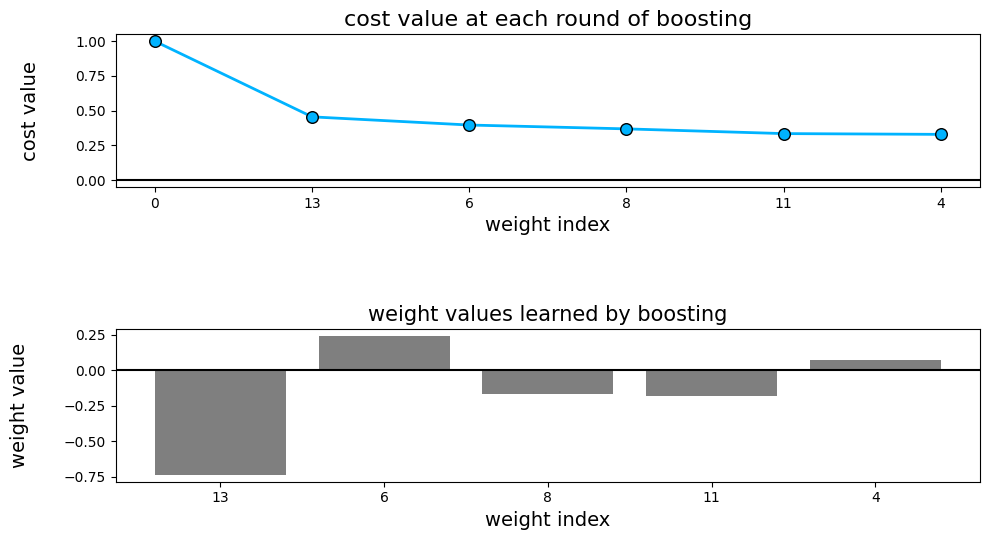

In [6]:
# load in data
data = np.loadtxt(data_path_1,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# import booster
mylib = section_9_6_helpers.BoostSetup(x,y)

# choose normalizer
mylib.choose_normalizer(name = 'standard')

# choose cost
mylib.choose_cost(name = 'least_squares')

# choose optimizer
mylib.choose_optimizer('newtons_method',max_its=1)

# run boosting
mylib.boost(num_rounds=5)

# plot round history
mylib.plot_history();

#### <span style="color:#a50e3e;">Example 2: </span>  Exploring features for classifying credit risk of loan applicants via boosting

Below we show the results of running the boosting procedure detailed above - using a Softmax cost and Newton's method optimizer - and a slightly adjusted version of the *German Credit* dataset which can be [downloaded here](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29).  

This is a two-class classification dataset consisting of $1000$ samples, each a set of statistics extracted from loan application to a German bank.  Each input then has an associated label - either a 'good' or 'bad' credit risk as determined by financial professionals.  In constructing a learned classifier for this dataset we create an auotmatic credit risk assessment tool that can help decide whether or not future applicants are good candidates for loans.

The $N=20$ dimensional input features includes features like: the individual's current account balance with the bank (feature 1), the duration (in months) of previous credit with the bank (feature 2), the payment status of any prior credit taken out with the bank (feature 3), the amount of credit currently had with the bank (feature 4), and the current value of their Savings/Stocks (feature 6).  These are precisely the top five features found via boosting.  As we can see in the bottom panel, unsurprisingly most of these top features are positively correlated with an individual being a 'good' or 'bad' credit risk.

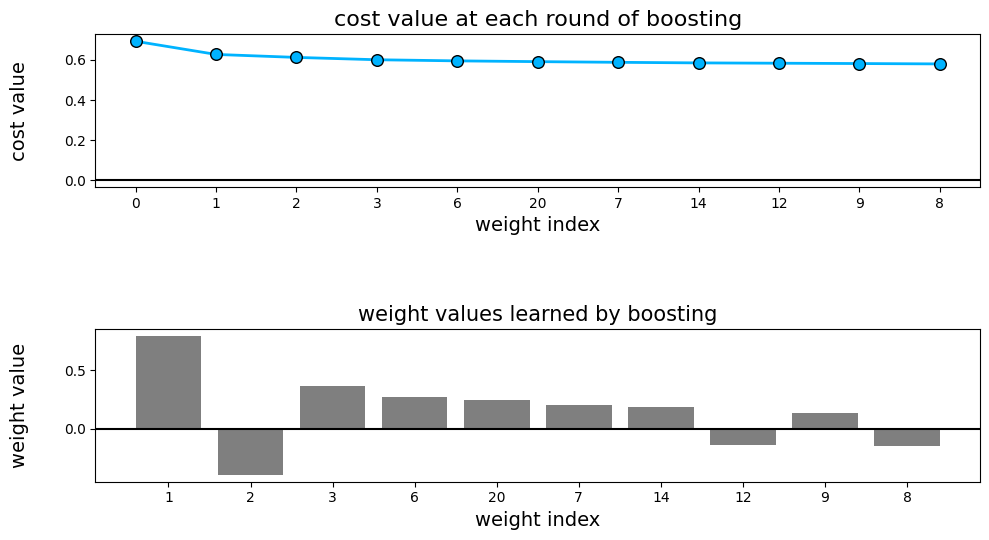

In [7]:
# load in dataset
data = np.loadtxt(data_path_2,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# import booster
mylib = section_9_6_helpers.BoostSetup(x,y)

# choose normalizer
mylib.choose_normalizer(name = 'standard')

# choose cost
mylib.choose_cost(name = 'softmax')

# choose optimizer
mylib.choose_optimizer('newtons_method',max_its=10)

# run boosting
mylib.boost(num_rounds=10)

# plot round history
mylib.plot_history();

##  Boosting is an effecient scheme

The *boosting* idea detailed above is a *greedy* algorithm, meaning that at each stage we choose the next most important feature-touching weight and tune it properly by literally *trying out all remaining feature-touching weights* by solving a set of respective subproblems, *not* by leveraging some abstract mathematical criterion.  While each round of boosting demands we solve a number of subproblems, each one is a minimization with respect to *only a single weight* and is therefore very easy to solve virtually regardless of the local optimization scheme used.  This makes *boosting* a computationally effective approach to feature selection, and allows it to scale to datasets with large $N$.  A weakness inherent in doing this - that is in determining *one feature-touching weight at a time* - is that interactions between features / feature-touching weights can be potentially missed.

To capture potentially missed interactions between groups of features  / weights one might naturally extend the boosting idea and try to add *a group of $R$ feature-touching weights* at each round instead of just one weight.  However a quick calculation shows that this idea would quickly fail to scale.  In order to determine the first best group of $R$ feature-touching weights at the the *first* stage of this approach we would need to try out *every combination of $R$ weights* by solving a subproblem for each.  The problem is that there are *combinatorially many subgroups of size $R$*.  More precisely there are ${N \choose R} = \frac{R!}{N!\left(N-R\right)!}$ subproblems, and thus equally many subproblems to solve (this is far too many problems to solve in practice e.g., ${100 \choose 5} = 75,287,520 $).

## The residual perspective on boosting regression

Let us examine the $n^{th}$ subproblem in the $M^{th}$ stage of boosting, that is the minimization of the Least Squares cost

\begin{equation}
 \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_{M-1}^{\,}\left(\mathbf{x}_p,\mathbf{w}\right) + w_n^{\,}x_{n,p}   - \overset{\,}{y}_{p}^{\,}\right)^{2}
\end{equation}

and re-arrange the terms in each summand and denote $r_p^M=\left(   \overset{\,}{y}_{p}^{\,} - \text{model}_{M-1}^{\,}\left(\mathbf{x}_p,\mathbf{w}\right)\right)$ 

\begin{equation}
 \frac{1}{P}\sum_{p=1}^{P}\left(w_n^{\,}x_{n,p} - r_p^M \right)^{2}.
\end{equation}

Notice that the term $r_p^M$ on the right hand side of each summand is *fixed*, since $w_n$ is the only weight being tuned here.  This term $r_p^M$ is the *residual* of the original output $y_p$ after the contribution of model $\text{model}_M$ has been subtracted off.  We can then think about each round of boosting as *determining the next feature that best correlates with the residual from the previous round*.  